# `TimeSeries` Tutorial
## imports

In [ ]:
# if the package is not installed in your python environment, run this to execute the notebook directly from inside the GitHub repository
%cd -q ..

In [2]:
import numpy as np
import pandas as pd
import pint
import xarray as xr
import sympy
from matplotlib import pyplot as plt

import weldx
import weldx.transformations as tf
import weldx.utility as ut

from weldx.asdf.extension import WeldxAsdfExtension, WeldxExtension
from weldx.asdf.tags.weldx.core.mathematical_expression import MathematicalExpression
from weldx.core import TimeSeries
from weldx import Q_
from weldx.constants import WELDX_UNIT_REGISTRY as UREG

In [3]:
def plot_ts(ts):
    fig, ax = plt.subplots(1,1)
    x = ts.time.data.astype('timedelta64[ms]').astype(int)/1000.0
    plt.plot(x,ts.data.magnitude,'-o')
    plt.xlabel("time / s")
    plt.ylabel(f"value / {ts.data.units}");

## about the `TimeSeries` class
The `TimeSeries` class is a general way to describe the behavior of a scalar or multidimensional quantity over time.

In principle, two different approaches can be taken to define this behavior:
  1. use a symbolic mathematical expression to exactly define the time dependent relationship
  2. provide discrete values with associated times and define how to interpolate the time dependent behavior between timesteps

After creating a `TimeSeries` we can query the values at any point in time using the `TimeSeries.interp_time()` method.

## about unit support when using `TimeSeries`
`TimeSeries` only works with `Quantity` objects to enforce consistency in handling unit conversions, that means that all values have to be associated with a unit. When working with dimensionless data, this has to be explicitly stated by providing a dimensionless unit `""`.
The preferred way to create quantity data is to use the weldx-`Q_` constructor.

## About time formats
  - Currently the time representation only supports relative `Timedelta`-like time values and no absolute `Timestamp` information.
  - To describe time values, either `pandas.TimedeltaIndex` or `pint.Quantity` describing time values are supported as we will show below.

## Discrete Values Examples
### simple constant examples
#### scalar constants
We start by creating the simplest `TimeSeries` object possible: a simple constant (scalar) value.
Since constant values are inherently independent of time we only have to provide the value to the `TimeSeries`. Keep in mind to use Quantities here as well.

Lets create a simple TimeSeries representing a constant frequency of 5 Hz.

In [4]:
ts_constant = TimeSeries(Q_(5,"Hz"))
print(ts_constant)

<TimeSeries>
Constant value:
	5
Units:
	hertz



Let's evaluate our constant timeseries at each second over a span of 10 seconds. To do this, we first create a `pandas.TimedeltaIndex` that represents our desired timespan.

In [5]:
t = pd.timedelta_range(start="0s",end="10s",freq="s")
t

TimedeltaIndex(['0 days 00:00:00', '0 days 00:00:01', '0 days 00:00:02',
                '0 days 00:00:03', '0 days 00:00:04', '0 days 00:00:05',
                '0 days 00:00:06', '0 days 00:00:07', '0 days 00:00:08',
                '0 days 00:00:09', '0 days 00:00:10'],
               dtype='timedelta64[ns]', freq='S')

We can now use these timestamps to evaluate our constant timeseries.

In [6]:
ts_constant.interp_time(time=t)

Magnitude,[5.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0]
Units,hertz


It is important to note, that `TimeSeries.interp_time()` will always return its results as an xarray object with the following structure:
  - a single named `time` dimension with the evaluated timestamps as coordinate values
  - the data consisting of our constant value as a `Quantity`

We can also create a simple plot:

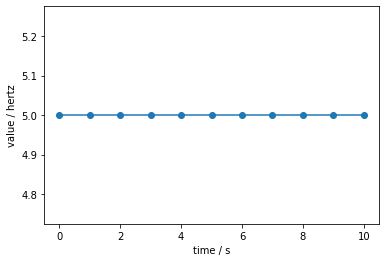

In [7]:
plot_ts(ts_constant.interp_time(time=t))

#### multi-dimensional constant example
We can also create multi-dimensional constant values. For this to work, we have to wrap our value into another dimension of length 1 to indicate a constant time axis.
For example, lets represent a single constant cartesian vector with our `TimeSeries`:

In [8]:
ts_constant_vector = TimeSeries(Q_([[0,2,10]],"cm"))
print(ts_constant_vector)

<TimeSeries>
Constant value:
	[ 0  2 10]
Units:
	centimeter



Interpolation still works as expected:

In [9]:
ts = ts_constant_vector.interp_time(time=t)
print(ts)

<xarray.DataArray (time: 11, dim_1: 3)>
<Quantity([[ 0.  2. 10.]
 [ 0.  2. 10.]
 [ 0.  2. 10.]
 [ 0.  2. 10.]
 [ 0.  2. 10.]
 [ 0.  2. 10.]
 [ 0.  2. 10.]
 [ 0.  2. 10.]
 [ 0.  2. 10.]
 [ 0.  2. 10.]
 [ 0.  2. 10.]], 'centimeter')>
Coordinates:
  * time     (time) timedelta64[ns] 00:00:00 00:00:01 ... 00:00:09 00:00:10
Dimensions without coordinates: dim_1


### Interpolation examples
The main idea of `TimeSeries` is to reflect time dependent data. For values that change over time, we can define discrete values at specific points in time and pass the interpolation method on to the `TimeSeries`.
Let's say we want a value representing a velocity that starts at 10 cm/min, jumps to 15 cm/min between 2 and 6 seconds of our experiment and stays at 8 cm/min afterwards.
To represent this behavior we can use the `step` interpolation method.

In [10]:
ts_step = TimeSeries(data=Q_([10,15,8],"cm/min"),time=pd.TimedeltaIndex(data=[0,2,6],unit="s"),interpolation="step")
ts_step

<TimeSeries>
Time:
	TimedeltaIndex(['0 days 00:00:00', '0 days 00:00:02', '0 days 00:00:06'], dtype='timedelta64[ns]', freq=None)
Values:
	[10 15  8]
Interpolation:
	step
Units:
	centimeter / minute

lets interpolate this to our previous timeline and see the results

<xarray.DataArray (time: 11)>
<Quantity([10 10 15 15 15 15  8  8  8  8  8], 'centimeter / minute')>
Coordinates:
  * time     (time) timedelta64[ns] 00:00:00 00:00:01 ... 00:00:09 00:00:10
Attributes:
    interpolation:  step


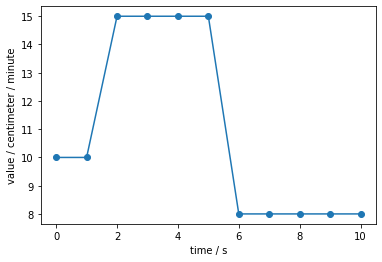

In [11]:
ts = ts_step.interp_time(t)
print(ts)
plot_ts(ts)

The second supported interpolation style is `linear`. Let's use this to create a timeseries that increases from 100 A to 200 A between 3 seconds and 7 seconds of the experiment.

In [12]:
ts_linear = TimeSeries(data=Q_([100,200],"A"),time=pd.TimedeltaIndex(data=[3,7],unit="s"),interpolation="linear")
ts_linear

<TimeSeries>
Time:
	TimedeltaIndex(['0 days 00:00:03', '0 days 00:00:07'], dtype='timedelta64[ns]', freq=None)
Values:
	[100 200]
Interpolation:
	linear
Units:
	ampere

<xarray.DataArray (time: 11)>
<Quantity([100. 100. 100. 100. 125. 150. 175. 200. 200. 200. 200.], 'ampere')>
Coordinates:
  * time     (time) timedelta64[ns] 00:00:00 00:00:01 ... 00:00:09 00:00:10


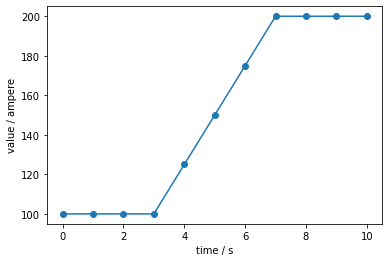

In [13]:
ts = ts_linear.interp_time(t)
print(ts)
plot_ts(ts)

One important note about `TimeSeries.interp_time()` that can be seen from the plot above:
Even though we only defined the `TimeSeries` discrete values at timesteps 3s and 7s, the interpolation gives back results outside of that timerange as well. This is the current intended behavior of all timeseries interpolations. The last defined values will be propagated as constant values outside of the initial time range. The initial and final values are preserved even when not included in the interpolation time.

<xarray.DataArray (time: 11)>
<Quantity([100.  100.  100.  112.5 137.5 162.5 187.5 200.  200.  200.  200. ], 'ampere')>
Coordinates:
  * time     (time) timedelta64[ns] 00:00:00.500000 ... 00:00:10.500000


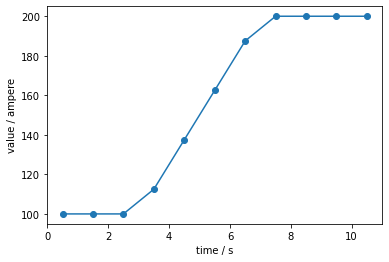

In [14]:
ts = ts_linear.interp_time(t+pd.Timedelta(0.5,"s"))
print(ts)
plot_ts(ts)

## Mathematical expression examples
The second method to describe our `TimeSeries` object is by providing a `MathematicalExpression` that can be evaluated against time parameters.

### linear equation example
Let's create a linear ramp function as an example: $f(t) = a*t + b$.

Note that all parameters must be defined as `Quantities` in a way that the expression correctly evaluates all dimensions when provided with a time-dimension input (in our case for parameter `t`)

<xarray.DataArray (time: 11)>
<Quantity([-10.  -8.  -6.  -4.  -2.   0.   2.   4.   6.   8.  10.], 'meter')>
Coordinates:
  * time     (time) timedelta64[ns] 00:00:00 00:00:01 ... 00:00:09 00:00:10


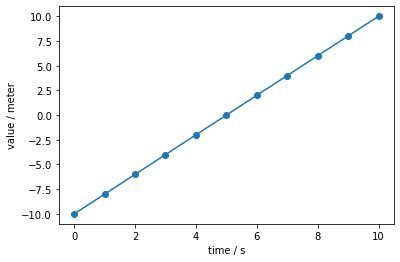

In [15]:
expr_string = "a*t+b"
parameters = {"a": Q_(120, "m/min"), "b": Q_(-10, "m")}
expr = MathematicalExpression(expression=expr_string, parameters=parameters)

ts_expr = TimeSeries(data=expr)

ts = ts_expr.interp_time(t)
print(ts)
plot_ts(ts)

We can also use `Quantites` with the appropriate dimension as Inputs for our interpolation:

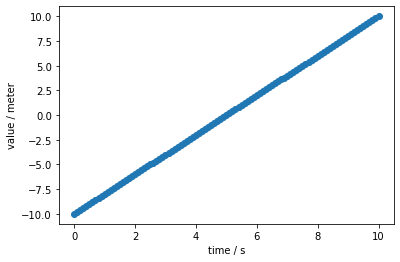

In [16]:
t2 = Q_(np.arange(101)*100,"ms")
ts = ts_expr.interp_time(t2)
plot_ts(ts)

### sine example
Of course we can also have more complex examples. Lets create a sine wave function that oscillates around 1 m at a frequency of 36 deg/s.

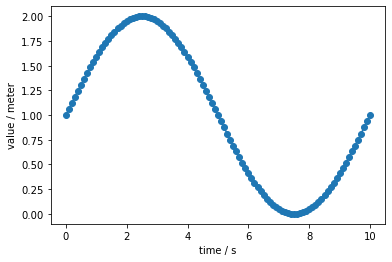

In [17]:
expr_string = "a*sin(o*t)+b"
parameters = {"a": Q_(1, "m"), "b": Q_(1, "m"),"o":Q_(36,"deg/s")}
expr = MathematicalExpression(expression=expr_string, parameters=parameters)

ts_sine = TimeSeries(data=expr)

ts = ts_sine.interp_time(pd.timedelta_range(start="0s",end="10s",freq="100ms"))
plot_ts(ts)

### vector example
With careful syntax it is also possible to create multidimensional `TimeSeries` objects from math expressions.

In [18]:
expr_string = "a*sin(o*t)+b*t"
parameters = {
    "a": Q_(np.asarray([[1, 0, 0]]), "m"), "b": Q_([[0, 1, 0]], "m/s"),"o":Q_(36,"deg/s")}
expr = MathematicalExpression(expression=expr_string, parameters=parameters)

ts_vector = TimeSeries(data=expr)

ts = ts_vector.interp_time(pd.timedelta_range(start="0s",end="10s",freq="500ms"))
print(ts)

<xarray.DataArray (time: 21, dim_1: 3)>
<Quantity([[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 3.09016994e-01  5.00000000e-01  0.00000000e+00]
 [ 5.87785252e-01  1.00000000e+00  0.00000000e+00]
 [ 8.09016994e-01  1.50000000e+00  0.00000000e+00]
 [ 9.51056516e-01  2.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  2.50000000e+00  0.00000000e+00]
 [ 9.51056516e-01  3.00000000e+00  0.00000000e+00]
 [ 8.09016994e-01  3.50000000e+00  0.00000000e+00]
 [ 5.87785252e-01  4.00000000e+00  0.00000000e+00]
 [ 3.09016994e-01  4.50000000e+00  0.00000000e+00]
 [ 1.22464680e-16  5.00000000e+00  0.00000000e+00]
 [-3.09016994e-01  5.50000000e+00  0.00000000e+00]
 [-5.87785252e-01  6.00000000e+00  0.00000000e+00]
 [-8.09016994e-01  6.50000000e+00  0.00000000e+00]
 [-9.51056516e-01  7.00000000e+00  0.00000000e+00]
 [-1.00000000e+00  7.50000000e+00  0.00000000e+00]
 [-9.51056516e-01  8.00000000e+00  0.00000000e+00]
 [-8.09016994e-01  8.50000000e+00  0.00000000e+00]
 [-5.87785252e-01  9.00000000e+0

Here is a plot showing the x,y,z coordinates:

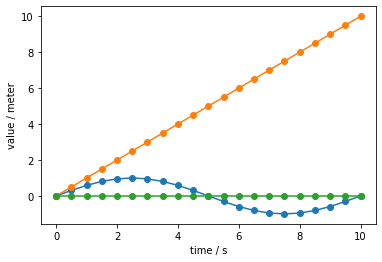

In [19]:
plot_ts(ts)

tests